In [1]:
!sudo apt -y install libportaudio2
!pip install tflite-model-maker

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 0s (147 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


In [1]:
#importing all the required libraries
import os
import glob
import random
import shutil

import librosa
import soundfile as sf
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
from tflite_model_maker.config import ExportFormat

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


TensorFlow Version: 2.8.2
Model Maker Version: 0.4.1


In [2]:
use_custom_dataset = True

In [3]:
#mounting the drive

from google.colab import drive
drive.mount('/content/mydrive')
if use_custom_dataset:
  # Specify the ZIP file you uploaded:
  
#unzipping the file
  !unzip '/content/mydrive/MyDrive/CPS584-ProjectDatasetUpdated.zip'
 
  data_dir = '/content/CPS584-ProjectDatasetUpdated'


Streaming output truncated to the last 5000 lines.
  inflating: CPS584-ProjectDatasetUpdated/C/C_256.wav  
  inflating: CPS584-ProjectDatasetUpdated/C/C_96.wav  
  inflating: CPS584-ProjectDatasetUpdated/C/C_82.wav  
  inflating: CPS584-ProjectDatasetUpdated/C/C_55.wav  
  inflating: CPS584-ProjectDatasetUpdated/C/C_41.wav  
  inflating: CPS584-ProjectDatasetUpdated/C/C_69.wav  
  inflating: CPS584-ProjectDatasetUpdated/C/C_336.wav  
  inflating: CPS584-ProjectDatasetUpdated/C/C_322.wav  
  inflating: CPS584-ProjectDatasetUpdated/C/C_444.wav  
  inflating: CPS584-ProjectDatasetUpdated/C/C_108.wav  
  inflating: CPS584-ProjectDatasetUpdated/C/C_134.wav  
  inflating: CPS584-ProjectDatasetUpdated/C/C_120.wav  
  inflating: CPS584-ProjectDatasetUpdated/C/C_147.wav  
  inflating: CPS584-ProjectDatasetUpdated/C/C_153.wav  
  inflating: CPS584-ProjectDatasetUpdated/C/C_184.wav  
  inflating: CPS584-ProjectDatasetUpdated/C/C_190.wav  
  inflating: CPS584-ProjectDatasetUpdated/C/C_379.wav  
  

In [4]:
#functions required for processing the audio file
def get_random_audio_file(samples_dir):
  files = os.path.abspath(os.path.join(samples_dir, '*/*.wav'))
  files_list = glob.glob(files)
  random_audio_path = random.choice(files_list)
  return random_audio_path

def show_sample(audio_path):
  audio_data, sample_rate = sf.read(audio_path)
  class_name = os.path.basename(os.path.dirname(audio_path))
  print(f'Class: {class_name}')
  print(f'File: {audio_path}')
  print(f'Sample rate: {sample_rate}')
  print(f'Sample length: {len(audio_data)}')

  plt.title(class_name)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

In [5]:


test_dir = './content/CPS584-ProjectDatasetUpdated-test'
 

#20% data as testing data
test_data_ratio = 0.2

dirs = glob.glob(os.path.join(data_dir, '*/'))
#print("dirs",dirs)
#moving all the 20% files to test directory
for dir in dirs:
  #print("outside fst for")
  files = glob.glob(os.path.join(dir, '*.wav'))
  test_count = round(len(files) * test_data_ratio)
  random.seed(42)
  random.shuffle(files)
    # Move test samples:
  for file in files[:test_count]:
    class_dir = os.path.basename(os.path.normpath(dir))
    os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
    os.rename(file, os.path.join(test_dir, class_dir, os.path.basename(file)))
  print('Moved', test_count, 'images from', class_dir)

#random_audio = get_random_audio_file('/content/CPS584-ProjectDatasetUpdated')



Moved 89 images from V
Moved 88 images from I
Moved 89 images from G
Moved 89 images from T
Moved 88 images from B
Moved 88 images from Z
Moved 89 images from D
Moved 88 images from X
Moved 89 images from Y
Moved 89 images from E
Moved 88 images from P
Moved 87 images from R
Moved 88 images from L
Moved 88 images from O
Moved 88 images from F
Moved 89 images from H
Moved 88 images from S
Moved 88 images from M
Moved 88 images from J
Moved 88 images from Q
Moved 89 images from U
Moved 87 images from W
Moved 89 images from C
Moved 88 images from K
Moved 87 images from N
Moved 89 images from A


Class: Q
File: /content/content/CPS584-ProjectDatasetUpdated-test/Q/Q_344.wav
Sample rate: 16000
Sample length: 19805


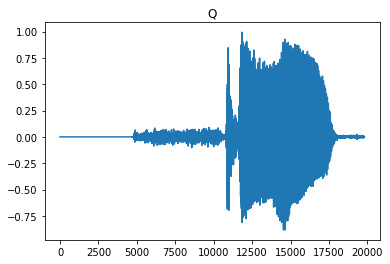

In [6]:
#testing for random audio
random_audio = get_random_audio_file(test_dir)
show_sample(random_audio)

Defining the model

In [7]:
#Type of audio input must be specified
#here browserFFT(browser fourier Tansform) input is considered
spec = audio_classifier.BrowserFftSpec()


INFO:tensorflow:Checkpoints are stored in /tmp/tmp0whp998a
32768/18467 [=====================================================] - 0s 0us/step
16384/203 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [8]:
#dataset is divided into training and test data 
if use_custom_dataset:
  #80% data as training data
  #Cache=True is used since it will be used for storing results of long computational operations
  #Data loader  API in audio classifier helps us to split  training set, validation and test set.
  train_data_ratio = 0.8
  train_data = audio_classifier.DataLoader.from_folder(
      spec, data_dir, cache=True)
  train_data, validation_data = train_data.split(train_data_ratio)
  test_data = audio_classifier.DataLoader.from_folder(
      spec, test_dir, cache=True)

Training the model

In [9]:
#usually preffered batch size is power of 2 
batch_size = 32
epochs = 50
#steps_per_epoch=175
model = audio_classifier.create(train_data, spec, validation_data, batch_size, epochs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 42, 225, 8)        136       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 112, 8)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 109, 32)       2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 51, 32)         8224      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 25, 32)       

In [10]:
#evalauating the model after training
model.evaluate(test_data)


61/61 [==============================] - 222s 4s/step - loss: 2.1083 - acc: 0.4591


[2.108344554901123, 0.45906734466552734]

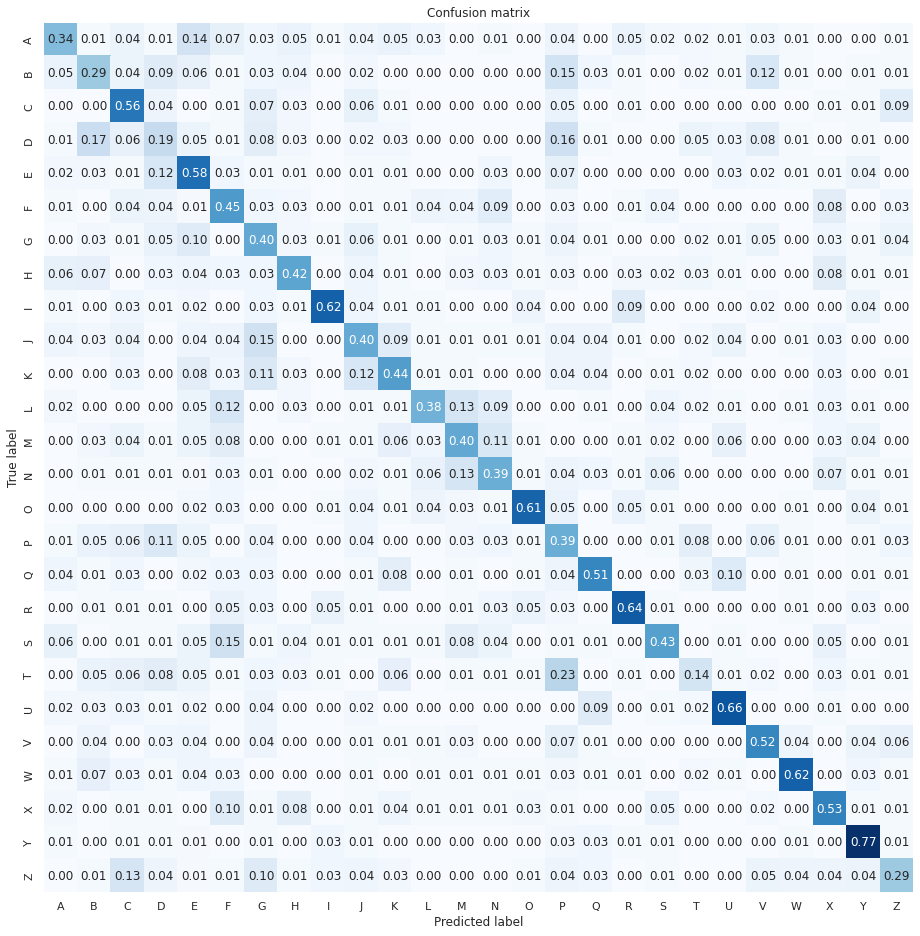

In [11]:
#printing the confusion matrix so the probability of each class can be known after training
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  sns.set(rc = {'figure.figsize':(16,16)})
  sns.heatmap(
      confusion_normalized, xticklabels=test_labels, yticklabels=test_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True, cbar=False)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

In [12]:
#converting model into the tflite model for mobile deployment compatabilty
TFLITE_FILENAME = 'speech_recognition_tflite_maker.tflite'
SAVE_PATH = '/content/mydrive/MyDrive/Tflite_files'

In [13]:
#exporting the .tflite model to the specified path
print(f'Exporing the model to {SAVE_PATH}')
model.export(SAVE_PATH, tflite_filename=TFLITE_FILENAME)
model.export(SAVE_PATH, export_format=[mm.ExportFormat.SAVED_MODEL, mm.ExportFormat.LABEL])

Exporing the model to /content/mydrive/MyDrive/Tflite_files
INFO:tensorflow:Assets written to: /tmp/tmplxvrj3e2/assets
INFO:tensorflow:TensorFlow Lite model exported successfully: /content/mydrive/MyDrive/Tflite_files/speech_recognition_tflite_maker.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: /content/mydrive/MyDrive/Tflite_files/speech_recognition_tflite_maker.tflite


INFO:tensorflow:Assets written to: /content/mydrive/MyDrive/Tflite_files/saved_model/assets


INFO:tensorflow:Assets written to: /content/mydrive/MyDrive/Tflite_files/saved_model/assets


INFO:tensorflow:Saving labels in /content/mydrive/MyDrive/Tflite_files/labels.txt


INFO:tensorflow:Saving labels in /content/mydrive/MyDrive/Tflite_files/labels.txt
